<a href="https://colab.research.google.com/github/mkuangdotcom/Music_Recommendation_System/blob/main/User_Centric_Approach_to__Music_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Recommendation System: Collaborative Filtering Approach

**Name:** Foo Ming Kuang

**Student ID:** 26130714

**Task Type:** Option 2 - Practical Machine Learning System  



# Problem Statement


Music streaming platforms face the challenge of recommending relevant content from millions of tracks. Simple popularity-based recommendations suffer from:
- **Popularity bias:** Already-popular items receive disproportionate exposure
- **Cold-start problems:** New artists struggle to gain visibility
- **Zero personalization:** All users receive identical recommendations
This project implements and compares three recommendation approaches:

1. Baseline: Popularity-based recommendations (recommend top songs to everyone)
2. ALS (Alternating Least Squares): Advanced collaborative filtering

In this project, we use the Last.fm 360K dataset, scaled to 20,000 users for computational efficiency.

Dataset: http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html (depreated)

Download link: https://zenodo.org/record/6090214/files/lastfm-dataset-360K.tar.gz

In [1]:
!pip install implicit pandas numpy scipy matplotlib seaborn scikit-learn tqdm

## Data Loading
About the dataset:
The Last.fm 360K dataset contains user-artist play counts from the Last.fm music streaming service. It includes:
- 360,000 users
- 170,000 artists
- 17 million play count records

In [2]:
!curl -L -o lastfm-dataset-360K.tar.gz https://zenodo.org/records/6090214/files/lastfm-dataset-360K.tar.gz

# Extract
!tar -xzf lastfm-dataset-360K.tar.gz

# Remove tar file
!rm lastfm-dataset-360K.tar.gz

data_path = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542M  100  542M    0     0  6354k      0  0:01:27  0:01:27 --:--:-- 3497k



The Last.fm 360K dataset contains the following variables:

*   **user_id:** A unique identifier for each user.
*   **artist_id:** A unique identifier for each artist.
*   **artist_name:** The name of the artist.
*   **play_count:** The number of times the user has played the artist's songs. This represents the strength of the implicit feedback.

In [3]:
import pandas as pd

# Load
df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['user_id', 'artist_id', 'artist_name', 'play_count'])

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique artists: {df['artist_id'].nunique():,}")
print(f"Play count range: {df['play_count'].min()} - {df['play_count'].max()}")

df.head()

Total interactions: 17,535,655
Unique users: 358,868
Unique artists: 160,112
Play count range: 0 - 419157


,user_id,artist_id,artist_name,play_count
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


## Visualize and Scale the Data

Visualizations of user play counts, artist popularity, and user activity distributions.

This helps understand data sparsity and long-tail distributions.

In [4]:
# User activity analysis
user_activity = df.groupby('user_id').agg({
    'artist_id': 'count',      # number of different artists
    'play_count': 'sum'        # total plays
}).rename(columns={'artist_id': 'num_artists', 'play_count': 'total_plays'})

print("User Activity Stats:")
print(f"Average artists per user: {user_activity['num_artists'].mean():.1f}")
print(f"Median artists per user: {user_activity['num_artists'].median()}")
print(f"Most active user: {user_activity['num_artists'].max()} artists")
print(f"Least active user: {user_activity['num_artists'].min()} artists")

# Artist popularity analysis
artist_popularity = df.groupby('artist_id').agg({
    'user_id': 'count',        # number of different users
    'play_count': 'sum'        # total plays
}).rename(columns={'user_id': 'num_listeners', 'play_count': 'total_plays'})

print("\nArtist Popularity Stats:")
print(f"Average listeners per artist: {artist_popularity['num_listeners'].mean():.1f}")
print(f"Median listeners per artist: {artist_popularity['num_listeners'].median()}")
print(f"Most popular artist: {artist_popularity['num_listeners'].max()} listeners")
print(f"Least popular artist: {artist_popularity['num_listeners'].min()} listeners")

User Activity Stats:
Average artists per user: 48.2
Median artists per user: 48.0
Most active user: 165 artists
Least active user: 0 artists

Artist Popularity Stats:
Average listeners per artist: 108.1
Median listeners per artist: 6.0
Most popular artist: 77254 listeners
Least popular artist: 1 listeners


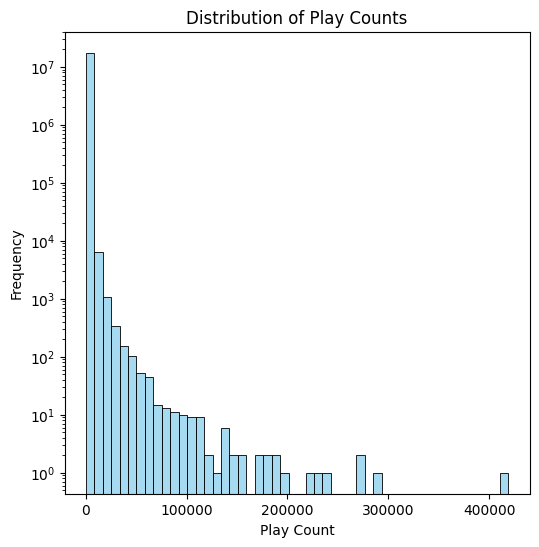

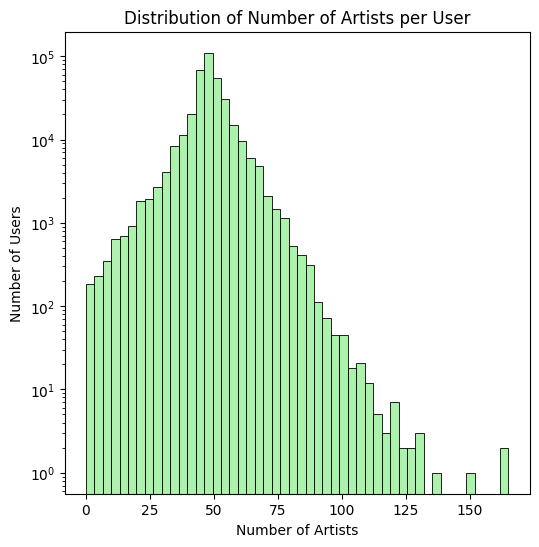

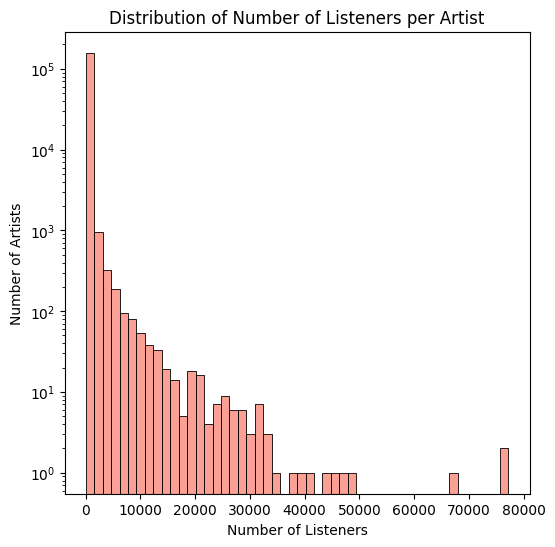

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate user activity
user_activity = df.groupby('user_id')['artist_id'].nunique().reset_index(name='num_artists')

# Calculate artist popularity
artist_popularity = df.groupby('artist_id')['user_id'].nunique().reset_index(name='num_listeners')

# Visualize play count distribution
plt.figure(figsize=(6, 6))
sns.histplot(df['play_count'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Play Counts')
plt.xlabel('Play Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# User activity distribution
plt.figure(figsize=(6, 6))
sns.histplot(user_activity['num_artists'], bins=50, kde=False, color='lightgreen')
plt.title('Distribution of Number of Artists per User')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.show()

# Artist popularity distribution
plt.figure(figsize=(6, 6))
sns.histplot(artist_popularity['num_listeners'], bins=50, kde=False, color='salmon')
plt.title('Distribution of Number of Listeners per Artist')
plt.xlabel('Number of Listeners')
plt.ylabel('Number of Artists')
plt.yscale('log')
plt.show()

## Filter and Scale

### Data Quality Considerations

**Why filter?**
1. **Cold-start mitigation:** Users/artists with too few interactions provide weak signals
2. **Computational efficiency:** Reducing matrix size speeds up training
3. **Data quality:** Very inactive users may be bots or inactive accounts

In [6]:
# Filter users with at least 5 unique artists
user_counts = df.groupby('user_id').size()
active_users = user_counts[user_counts >= 5].index
df_filtered = df[df['user_id'].isin(active_users)]

# Filter artists with at least 5 unique listeners
artist_counts = df_filtered.groupby('artist_id').size()
popular_artists = artist_counts[artist_counts >= 5].index
df_filtered = df_filtered[df_filtered['artist_id'].isin(popular_artists)]

# Scale down to the top 20,000 users
top_users = df_filtered['user_id'].value_counts().head(20000).index
df_scaled = df_filtered[df_filtered['user_id'].isin(top_users)]


print(f"Final scaled data: {len(df_scaled):,} interactions")
print(f"Users: {df_scaled['user_id'].nunique():,}")
print(f"Artists: {df_scaled['artist_id'].nunique():,}")

Final scaled data: 1,357,087 interactions
Users: 20,000
Artists: 66,959


## Preprocessing
Why sparse matrix?
- Sparse matrices efficiently store user-item interactions, saving memory and speeding up computations for large datasets with many missing values.


In [7]:
from scipy.sparse import csr_matrix

df_scaled = df_scaled.copy()

# Create user and artist mappings to indices
user_mapping = {user: idx for idx, user in enumerate(df_scaled['user_id'].unique())}
artist_mapping = {artist: idx for idx, artist in enumerate(df_scaled['artist_id'].unique())}

# Map IDs to indices
user_mapping = {user: idx for idx, user in enumerate(df_scaled['user_id'].unique())}
artist_mapping = {artist: idx for idx, artist in enumerate(df_scaled['artist_id'].unique())}

# Create reverse mappings
idx_to_artist_id = {idx: artist_id for artist_id, idx in artist_mapping.items()}
artist_id_to_name = dict(zip(df_scaled['artist_id'], df_scaled['artist_name']))

def get_artist_name(artist_idx):
    """Convert artist index to artist name"""
    artist_id = idx_to_artist_id.get(artist_idx)
    return artist_id_to_name.get(artist_id, f"Unknown Artist {artist_idx}")

df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)
df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)

# Create sparse matrix
rows = df_scaled['user_idx'].values
cols = df_scaled['artist_idx'].values
data = df_scaled['play_count'].values
sparse_matrix = csr_matrix((data, (rows, cols)),
                           shape=(len(user_mapping), len(artist_mapping)))

# Sparse Matrix Statistics
print(f"\nSparse Matrix Statistics:")
print(f"Shape: {sparse_matrix.shape}")
print(f"Total possible entries: {sparse_matrix.shape[0] * sparse_matrix.shape[1]:,}")
print(f"Non-zero entries: {sparse_matrix.nnz:,}")
sparsity_percent = (1 - sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1])) * 100
print(f"Sparsity: {sparsity_percent:.2f}%")
print(f"Density: {100 - sparsity_percent:.2f}%")


Sparse Matrix Statistics:
Shape: (20000, 66959)
Total possible entries: 1,339,180,000
Non-zero entries: 1,357,032
Sparsity: 99.90%
Density: 0.10%


## Train/Test Split

In [8]:
import numpy as np

# Split into train and test sets
train_matrix = sparse_matrix.copy()
test_interactions = []

test_ratio = 0.2 # 20% for testing
min_interactions = 5  # only consider users with at least 5 interactions

# For each user, randomly select some interactions for the test set
for user_idx in range(sparse_matrix.shape[0]):
    user_interactions = sparse_matrix.getrow(user_idx)
    nonzero_items = user_interactions.nonzero()[1]

    if len(nonzero_items) >= min_interactions:
        n_test = max(1, int(len(nonzero_items) * test_ratio))
        test_items = np.random.choice(nonzero_items, n_test, replace=False)

        for item_idx in test_items:
            test_interactions.append({
                'user_idx': user_idx,
                'item_idx': item_idx,
                'rating': sparse_matrix[user_idx, item_idx]
            })
            train_matrix[user_idx, item_idx] = 0

train_matrix.eliminate_zeros()

print(f"\nTrain Matrix Statistics:")
print(f"Shape: {train_matrix.shape}")
print(f"Total possible entries: {train_matrix.shape[0] * train_matrix.shape[1]:,}")
print(f"Non-zero entries: {train_matrix.nnz:,}")
train_sparsity = (1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Train set sparsity: {train_sparsity:.2f}%")


Train Matrix Statistics:
Shape: (20000, 66959)
Total possible entries: 1,339,180,000
Non-zero entries: 1,093,796
Train set sparsity: 99.92%


Data leackage prevention: Ensure each user has interactions in both train and test sets.

In [9]:
# Check for data leakage
assert train_matrix.nnz + len(test_interactions) == sparse_matrix.nnz, "Data leakage detected"

# Check sparsity
train_sparsity = (1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Train set sparsity: {train_sparsity:.2f}%")

# Check for cold-start users
train_user_counts = np.array(train_matrix.sum(axis=1)).flatten()
cold_start_users = np.sum(train_user_counts == 0)
print(f"Cold-start users: {cold_start_users}")

Train set sparsity: 99.92%
Cold-start users: 0


## Model Implementation and Training

We'll implement two advanced recommendation approaches:
1. **Baseline**: Popularity-based recommendations for comparison
2. **ALS (Alternating Least Squares)**: Matrix factorization optimized for implicit feedback

### Baseline Model: Popularity-Based Recommendations

First, let's establish our baseline by identifying the most popular artists based on total play counts across all training users.

**Hypothesis Space:** H_baseline = {h}  
where h is a single function:

```
h(u) = [a₁, a₂, ..., a₁₀] for all users u
```

Artists are ranked by global popularity: `popularity(j) = Σrᵢⱼ`

**Characteristics:**
- |H| = 1 (single hypothesis)
- No learnable parameters
- Zero generalization challenge (memorization of training data)

In [10]:
# Calculate artist popularity from training data
artist_popularity = np.array(train_matrix.sum(axis=0)).flatten()

# Get top artists for baseline recommendations
n_recommendations = 10
top_artists_baseline = np.argsort(artist_popularity)[::-1][:n_recommendations]

print("Baseline Model - Most Popular Artists:")
for i, artist_idx in enumerate(top_artists_baseline):
    plays = artist_popularity[artist_idx]
    print(f"  {i+1}. Artist {artist_idx}: {plays:,.0f} total plays")

Baseline Model - Most Popular Artists:
  1. Artist 156: 1,015,612 total plays
  2. Artist 305: 712,181 total plays
  3. Artist 816: 505,658 total plays
  4. Artist 344: 503,991 total plays
  5. Artist 421: 436,294 total plays
  6. Artist 304: 412,446 total plays
  7. Artist 674: 402,067 total plays
  8. Artist 2425: 367,501 total plays
  9. Artist 315: 345,315 total plays
  10. Artist 134: 337,063 total plays


### ALS Model: Collaborative Filtering

ALS (Alternating Least Squares) is a matrix factorization technique that learns latent user and item factors by alternately optimizing user and item representations. It's particularly well-suited for implicit feedback data like play counts.

Key advantages:
- Handles sparse matrices efficiently
- Optimized for implicit feedback (play counts vs explicit ratings)
- Scalable to large datasets


The implicit library's AlternatingLeastSquares implements our hypothesis space:
H_ALS = {h | h(i,j) = uᵢᵀvⱼ, where U ∈ ℝ^(n×k), V ∈ ℝ^(m×k)}

**Mathematical Mapping:**
- `factors` → k (latent dimensionality)
- `regularization` → λ in λ(||uᵢ||² + ||vⱼ||²)
- `alpha` → α in confidence formula cᵢⱼ = 1 + α × rᵢⱼ
- Internal matrices `model.user_factors` → U matrix
- Internal matrices `model.item_factors` → V matrix

In [22]:
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm

def evaluate(model, test_sample, k=10):
    """
      Quick evaluation on sample of test data for hyperparameter search.

      Args:
          model: Trained ALS model
          test_sample (list): Test interactions
          k (int): Number of recommendations

      Returns:
          float: Average precision@k across sampled users
    """
    precisions = []

    # Sample 1000 users for fast evaluation
    user_test_items = {}
    for interaction in test_sample:
        user_idx = interaction['user_idx']
        if user_idx not in user_test_items:
            user_test_items[user_idx] = []
        user_test_items[user_idx].append(interaction['item_idx'])
        if len(user_test_items) >= 1000:
            break

    for user_idx, true_items in user_test_items.items():
        try:
            user_items = train_matrix[user_idx].tocsr()  # Get user's know interactions (to exclude from recommendations)
            recs, _ = model.recommend(userid=user_idx, user_items=user_items, N=k) # uᵢᵀvⱼ for all items j
            hits = len(set(recs) & set(true_items))
            precisions.append(hits / k)
        except:
            precisions.append(0)

    return np.mean(precisions)

# Parameter search space
param_space = {
    'factors': [30, 50, 70, 100],
    'regularization': [0.001, 0.01, 0.05, 0.1],
    'iterations': [10, 15, 20],
    'alpha': [0.5, 1.0, 2.0, 5.0]
}

# Random search configuration
n_trials = 12
results = []

print(f"Random Hyperparameter Search: {n_trials} trials")
print("-" * 60)

for trial in tqdm(range(n_trials), desc="Searching hyperparameters", ncols=80):
    # Sample random parameters
    params = {
        'factors': np.random.choice(param_space['factors']),
        'regularization': np.random.choice(param_space['regularization']),
        'iterations': np.random.choice(param_space['iterations']),
        'alpha': np.random.choice(param_space['alpha']),
        'random_state': 42
    }

    # Train and evaluate
    model = AlternatingLeastSquares(**params)
    model.fit(train_matrix.tocsr(), show_progress=False)
    precision = evaluate(model, test_interactions, k=10)

    tqdm.write(f"Trial {trial+1:2d}: P@10={precision:.4f} | "
               f"f={params['factors']:3d} r={params['regularization']:.3f} "
               f"i={params['iterations']:2d} a={params['alpha']:.1f}")

    results.append({
        **params,
        'precision': precision,
    })

# Results summary
results_df = pd.DataFrame(results).sort_values('precision', ascending=False)
print("-" * 60)
print("Top 3 Configurations:")
print(results_df[['factors', 'regularization', 'iterations', 'alpha', 'precision']].head(3).to_string(index=False))

# Best parameters
best = results_df.iloc[0]
print("-" * 60)
print("Best Parameters:")
print(f"  factors={int(best['factors'])}, regularization={best['regularization']}, "
      f"iterations={int(best['iterations'])}, alpha={best['alpha']}")
print(f"  Validation Precision@10: {best['precision']:.4f}")




Random Hyperparameter Search: 12 trials
------------------------------------------------------------


Searching hyperparameters:   8%|█▍               | 1/12 [00:23<04:13, 23.06s/it]

Trial  1: P@10=0.1327 | f= 50 r=0.050 i=20 a=0.5


Searching hyperparameters:  17%|██▊              | 2/12 [00:38<03:05, 18.56s/it]

Trial  2: P@10=0.1421 | f=100 r=0.100 i=15 a=0.5


Searching hyperparameters:  25%|████▎            | 3/12 [00:48<02:13, 14.81s/it]

Trial  3: P@10=0.0796 | f= 70 r=0.050 i=10 a=5.0


Searching hyperparameters:  33%|█████▋           | 4/12 [00:59<01:45, 13.21s/it]

Trial  4: P@10=0.0981 | f= 30 r=0.001 i=15 a=2.0


Searching hyperparameters:  42%|███████          | 5/12 [01:06<01:16, 10.91s/it]

Trial  5: P@10=0.0753 | f= 50 r=0.050 i=10 a=5.0


Searching hyperparameters:  50%|████████▌        | 6/12 [01:14<01:00, 10.09s/it]

Trial  6: P@10=0.0806 | f= 70 r=0.100 i=10 a=5.0


Searching hyperparameters:  58%|█████████▉       | 7/12 [01:25<00:51, 10.23s/it]

Trial  7: P@10=0.0789 | f=100 r=0.010 i=10 a=5.0


Searching hyperparameters:  67%|███████████▎     | 8/12 [01:32<00:36,  9.14s/it]

Trial  8: P@10=0.1346 | f= 50 r=0.050 i=10 a=0.5


Searching hyperparameters:  75%|████████████▊    | 9/12 [01:48<00:34, 11.37s/it]

Trial  9: P@10=0.1014 | f= 50 r=0.001 i=20 a=2.0


Searching hyperparameters:  83%|█████████████▎  | 10/12 [02:03<00:24, 12.50s/it]

Trial 10: P@10=0.1351 | f= 50 r=0.100 i=20 a=0.5


Searching hyperparameters:  92%|██████████████▋ | 11/12 [02:10<00:10, 10.80s/it]

Trial 11: P@10=0.0730 | f= 50 r=0.010 i=10 a=5.0


Searching hyperparameters: 100%|████████████████| 12/12 [02:21<00:00, 11.81s/it]

Trial 12: P@10=0.1370 | f=100 r=0.010 i=10 a=0.5
Top 3 Configurations:
 factors  regularization  iterations  alpha  precision
     100            0.10          15    0.5     0.1421
     100            0.01          10    0.5     0.1370
      50            0.10          20    0.5     0.1351
Best Parameters:
  factors=100, regularization=0.1, iterations=15, alpha=0.5
  Validation Precision@10: 0.1421


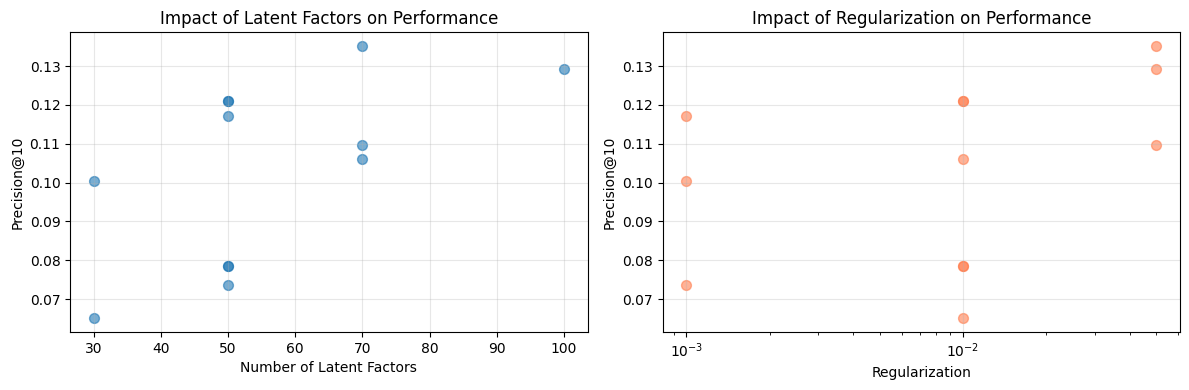

In [12]:
# Visualize hyperparameter impact
results_df = pd.DataFrame(results).sort_values('precision', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Impact of factors
axes[0].scatter(results_df['factors'], results_df['precision'], alpha=0.6, s=50)
axes[0].set_xlabel('Number of Latent Factors')
axes[0].set_ylabel('Precision@10')
axes[0].set_title('Impact of Latent Factors on Performance')
axes[0].grid(alpha=0.3)

# Impact of regularization
axes[1].scatter(results_df['regularization'], results_df['precision'],
                alpha=0.6, s=50, color='coral')
axes[1].set_xlabel('Regularization')
axes[1].set_ylabel('Precision@10')
axes[1].set_title('Impact of Regularization on Performance')
axes[1].set_xscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Iterations:  1 → Precision@10: 0.0190
Iterations:  3 → Precision@10: 0.1108
Iterations:  5 → Precision@10: 0.1265
Iterations: 10 → Precision@10: 0.1382
Iterations: 15 → Precision@10: 0.1421
Iterations: 20 → Precision@10: 0.1436


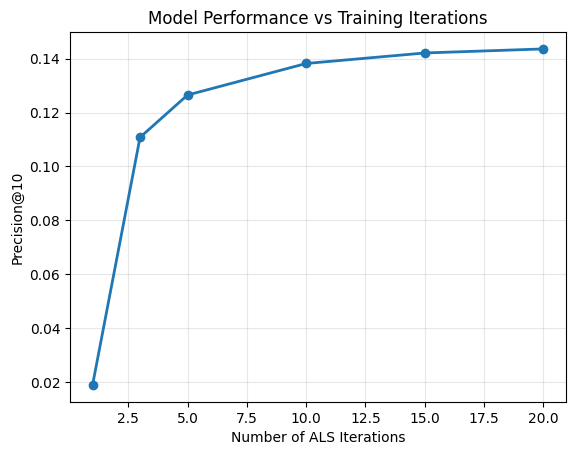

In [24]:
# Show how performance improves with more iterations
iteration_counts = [1, 3, 5, 10, 15, 20]
precisions = []

for n_iter in iteration_counts:
    model = AlternatingLeastSquares(
        factors=100, regularization=0.1,
        iterations=n_iter, alpha=0.5, random_state=42
    )
    model.fit(train_matrix, show_progress=False)
    precision = evaluate(model, test_interactions, k=10)
    precisions.append(precision)
    print(f"Iterations: {n_iter:2d} → Precision@10: {precision:.4f}")

# Plot convergence
plt.plot(iteration_counts, precisions, marker='o', linewidth=2)
plt.xlabel('Number of ALS Iterations')
plt.ylabel('Precision@10')
plt.title('Model Performance vs Training Iterations')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Train final model with best parameters
als_model = AlternatingLeastSquares(
    factors=int(best['factors']),
    regularization=best['regularization'],
    iterations=int(best['iterations']),
    alpha=best['alpha'],
    random_state=42
)
als_model.fit(train_matrix.tocsr(), show_progress=True)
print("Training complete.")

  0%|          | 0/15 [00:00<?, ?it/s]

Training complete.


## Recommendation Generation Functions

We'll implement functions to generate recommendations from both our baseline and ALS models, then evaluate their performance using standard recommendation metrics.

In [14]:
def get_baseline_recommendations(k=10):
    """Return top K popular artists."""
    return top_artists_baseline[:k]

def get_als_recommendations(user_idx, k=10):
    """
    Get personalized ALS recommendations for a user.

    Args:
        user_idx: user index (0 to n_users-1)
        k: number of recommendations

    Returns:
        artist_indices: array of recommended artist IDs
        scores: prediction scores
    """
    try:
        # Get user's listening history (for filtering)
        user_items = train_matrix[user_idx].tocsr()

        recs, scores = als_model.recommend(
            userid=user_idx,
            user_items=user_items,
            N=k,
            filter_already_liked_items=True
        )
        return recs, scores

    except Exception as e:
        print(f"Error getting recommendations for user {user_idx}: {e}")
        # Fallback to baseline
        return np.array([]), np.array([])

# Test the functions
print("Testing recommendation functions.")
test_user = 0
baseline_recs = get_baseline_recommendations(5)
als_recs, als_scores = get_als_recommendations(test_user, 5)

print(f"Baseline recommendations: {baseline_recs}")
print(f"ALS recommendations for user {test_user}: {als_recs}")
print(f"ALS scores: {als_scores}")

Testing recommendation functions...
Baseline recommendations: [156 305 816 344 421]
ALS recommendations for user 0: [ 264  413    9   36 8748]
ALS scores: [1.4043107 1.2438602 1.2266251 1.1947348 1.1586053]


## Model Evaluation and Comparison

Now we'll evaluate both models on our test set and compare their performance across multiple metrics.

In [15]:
def evaluate_recommendations(model_name, get_recs_func, test_interactions, k=10):
    """
    Evaluate recommendation quality using multiple metrics.

    Args:
        model_name (str): Name of the model being evaluated
        get_recs_func (function): Function that generates recommendations
                                   For baseline: takes only k
                                   For other models: takes (user_idx, k)
        test_interactions (list): List of test interaction dictionaries with keys:
                                  'user_idx', 'item_idx', 'rating'
        k (int): Number of recommendations to evaluate (default: 10)

    Returns:
        dict: Dictionary containing evaluation metrics:
              - precision: Average precision@k across all users
              - recall: Average recall@k across all users
              - ndcg: Average NDCG@k across all users
              - coverage: Fraction of items recommended at least once
              - name: Model name string
    """
    print(f"\nEvaluating {model_name}...")

    # Group test items by user
    user_test_items = {}
    for interaction in test_interactions:
        user_idx = interaction['user_idx']
        artist_idx = interaction['item_idx']
        if user_idx not in user_test_items:
            user_test_items[user_idx] = []
        user_test_items[user_idx].append(artist_idx)

    print(f"  Evaluating on {len(user_test_items)} users")

    precisions = []
    recalls = []
    ndcgs = []
    all_recommended = set()

    for user_idx, true_items in user_test_items.items():
        # Get recommendations based on model type
        if model_name == "Baseline":
            recs = get_recs_func(k)
        else:
            recs, _ = get_recs_func(user_idx, k)

        # Ensure recommendations are valid indices
        recs = np.array(recs)
        valid_recs = recs[recs < train_matrix.shape[1]]

        # Calculate hits
        rec_set = set(valid_recs)
        true_set = set(true_items)
        hits = len(rec_set & true_set)

        # Precision@k: fraction of recommendations that are relevant
        precision = hits / k if k > 0 else 0
        precisions.append(precision)

        # Recall@k: fraction of relevant items that are recommended
        recall = hits / len(true_set) if len(true_set) > 0 else 0
        recalls.append(recall)

        # NDCG@k: ranking quality metric (relevant items at top positions score higher)
        dcg = 0.0
        for i, item in enumerate(valid_recs[:k]):
            if item in true_set:
                dcg += 1.0 / np.log2(i + 2)

        idcg = 0.0
        for i in range(min(len(true_set), k)):
            idcg += 1.0 / np.log2(i + 2)

        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)

        # Track all recommended items for coverage
        all_recommended.update(valid_recs)

    # Calculate average metrics
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    coverage = len(all_recommended) / train_matrix.shape[1]

    print(f"  Precision@{k}: {avg_precision:.4f}")
    print(f"  Recall@{k}: {avg_recall:.4f}")
    print(f"  NDCG@{k}: {avg_ndcg:.4f}")
    print(f"  Coverage: {coverage:.4f}")

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'ndcg': avg_ndcg,
        'coverage': coverage,
        'name': model_name
    }

In [16]:
# Evaluate baseline
baseline_results = evaluate_recommendations(
    "Baseline",
    get_baseline_recommendations,
    test_interactions,
    k=10
)

# Evaluate ALS
als_results = evaluate_recommendations(
    "ALS",
    get_als_recommendations,
    test_interactions,
    k=10
)

# Compare results
print(f"\n{'Metric':<15} {'Baseline':<12} {'ALS':<12} {'Improvement'}")
print("-"*60)
for metric in ['precision', 'recall', 'ndcg', 'coverage']:
    base = baseline_results[metric]
    als = als_results[metric]
    improvement = ((als - base) / base * 100) if base > 0 else 0
    print(f"{metric.capitalize():<15} {base:<12.4f} {als:<12.4f} {improvement:>+7.1f}%")


Evaluating Baseline...
  Evaluating on 20000 users
  Precision@10: 0.0282
  Recall@10: 0.0217
  NDCG@10: 0.0322
  Coverage: 0.0001

Evaluating ALS...
  Evaluating on 20000 users
  Precision@10: 0.1368
  Recall@10: 0.1049
  NDCG@10: 0.1543
  Coverage: 0.0650

Metric          Baseline     ALS          Improvement
------------------------------------------------------------
Precision       0.0282       0.1368        +384.8%
Recall          0.0217       0.1049        +384.2%
Ndcg            0.0322       0.1543        +379.9%
Coverage        0.0001       0.0650       +43440.0%


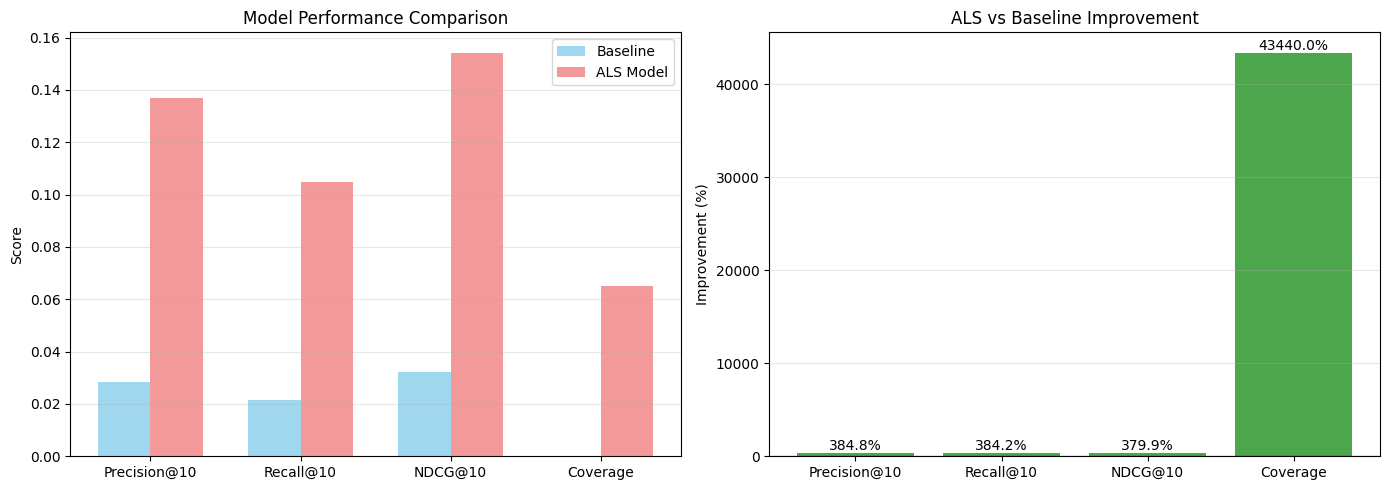

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance comparison
metrics = ['Precision@10', 'Recall@10', 'NDCG@10', 'Coverage']
baseline_vals = [baseline_results['precision'], baseline_results['recall'], baseline_results['ndcg'], baseline_results['coverage']]
als_vals = [als_results['precision'], als_results['recall'], als_results['ndcg'], als_results['coverage']]


x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, als_vals, width, label='ALS Model', alpha=0.8, color='lightcoral')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Improvement percentages
improvements = []
for base, als in zip(baseline_vals, als_vals):
    imp = ((als - base) / base * 100) if base > 0 else 0
    improvements.append(imp)

colors = ['green' if x > 0 else 'red' for x in improvements]
bars = axes[1].bar(metrics, improvements, color=colors, alpha=0.7)
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('ALS vs Baseline Improvement')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, improvements):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + (2 if height > 0 else -5),
                f'{val:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

In [19]:
# Create user_test_items dictionary from test_interactions
user_test_items = {}
for interaction in test_interactions:
    user_idx = interaction['user_idx']
    item_idx = interaction['item_idx']
    if user_idx not in user_test_items:
        user_test_items[user_idx] = []
    user_test_items[user_idx].append(item_idx)

print(f"Created test dictionary for {len(user_test_items)} users")

Created test dictionary for 20000 users


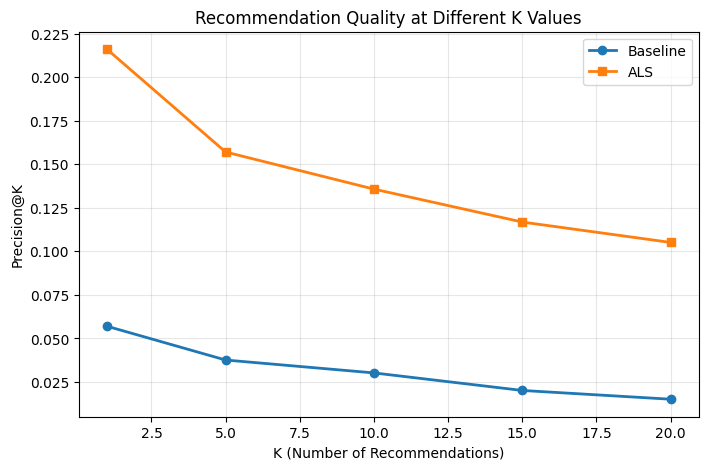

In [20]:
# Evaluate at different K values
k_values = [1, 5, 10, 15, 20]
baseline_prec_k = []
als_prec_k = []

# Sample 1000 users for speed
sample_users = np.random.choice(len(user_test_items),
                                min(1000, len(user_test_items)),
                                replace=False)

for k in k_values:
    b_prec, a_prec = [], []

    for i in sample_users:
        user_idx = list(user_test_items.keys())[i]
        true_items = user_test_items[user_idx]

        b_recs = get_baseline_recommendations(k)
        b_hits = len(set(b_recs) & set(true_items))
        b_prec.append(b_hits / k if k > 0 else 0)

        a_recs, _ = get_als_recommendations(user_idx, k)
        a_hits = len(set(a_recs) & set(true_items))
        a_prec.append(a_hits / k if k > 0 else 0)

    baseline_prec_k.append(np.mean(b_prec))
    als_prec_k.append(np.mean(a_prec))

plt.figure(figsize=(8, 5))
plt.plot(k_values, baseline_prec_k, marker='o', label='Baseline', linewidth=2)
plt.plot(k_values, als_prec_k, marker='s', label='ALS', linewidth=2)
plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Precision@K')
plt.title('Recommendation Quality at Different K Values')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Sample Recommendations Analysis

Let's examine actual recommendations for a sample user to understand the difference between baseline and collaborative filtering approaches.

In [23]:
sample_user = 0

# User's profile
user_artists = train_matrix[sample_user].nonzero()[1]
total_plays = train_matrix[sample_user].sum()

print(f"Sample User {sample_user} Profile:")
print(f"  Artists listened to: {len(user_artists)}")
print(f"  Total plays: {total_plays}")

# Show what they actually listen to
print(f"\n  Top 5 artists in listening history:")
user_plays = [(idx, train_matrix[sample_user, idx]) for idx in user_artists]
user_plays.sort(key=lambda x: x[1], reverse=True)
for i, (artist_idx, plays) in enumerate(user_plays[:5]):
    print(f"    {i+1}. {get_artist_name(artist_idx)} ({int(plays):,} plays)")

# Get recommendations
baseline_recs = get_baseline_recommendations(5)
als_recs, als_scores = get_als_recommendations(sample_user, 5)

print(f"\nBaseline Recommendations (Same for Everyone):")
for i, artist_idx in enumerate(baseline_recs):
    plays = int(artist_popularity[artist_idx])
    print(f"  {i+1}. Artist {artist_idx} ({plays:,} total plays)")

print(f"\nALS Recommendations (Personalized for User {sample_user}):")
for i, (artist_idx, score) in enumerate(zip(als_recs, als_scores)):
    print(f"  {i+1}. {get_artist_name(artist_idx)} (score: {score:.3f})")

# Check against test set
user_test_items = [item['item_idx'] for item in test_interactions if item['user_idx'] == sample_user]
if user_test_items:
    baseline_hits = len(set(baseline_recs) & set(user_test_items))
    als_hits = len(set(als_recs) & set(user_test_items))
    print(f"\nActual Relevance (Test Set Hits):")
    print(f"  Baseline: {baseline_hits}/5")
    print(f"  ALS: {als_hits}/5")

Sample User 0 Profile:
  Artists listened to: 52
  Total plays: 12727

  Top 5 artists in listening history:
    1. master's hammer (748 plays)
    2. misfits (726 plays)
    3. rubella ballet (687 plays)
    4. cauda pavonis (609 plays)
    5. creepersin (583 plays)

Baseline Recommendations (Same for Everyone):
  1. Artist 156 (1,015,612 total plays)
  2. Artist 305 (712,181 total plays)
  3. Artist 816 (505,658 total plays)
  4. Artist 344 (503,991 total plays)
  5. Artist 421 (436,294 total plays)

ALS Recommendations (Personalized for User 0):
  1. the doors (score: 1.404)
  2. tom waits (score: 1.244)
  3. inkubus sukkubus (score: 1.227)
  4. christian death (score: 1.195)
  5. horrorpops (score: 1.159)

Actual Relevance (Test Set Hits):
  Baseline: 0/5
  ALS: 2/5
